### Import Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.correlation import plot_corr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_model = pd.read_csv('df_combined.csv')

In [3]:
df_model

,Classification_Size,Classification_Focus,Research_Intensity,Status,Academic_Reputation_Score,Employer_Reputation_Score,Faculty_Student_Score,Citations_Per_Faculty_Score,International_Faculty_Score,International_Student_Score,Overall_Score
0,M,CO,VH,B,100.0,100.0,100.0,99.9,100.0,96.1,100.0
1,L,FC,VH,B,100.0,100.0,100.0,99.4,99.6,72.7,98.7
2,L,FC,VH,B,100.0,100.0,98.3,99.9,96.5,75.2,98.4
3,S,CO,VH,B,99.5,85.4,100.0,100.0,93.4,89.2,97.7
4,L,FC,VH,A,100.0,100.0,100.0,78.3,97.4,97.7,95.6
...,...,...,...,...,...,...,...,...,...,...,...
2498,L,FO,VH,A,34.9,25.1,28.8,24.6,13.4,47.4,9.1
2499,L,FO,VH,A,34.6,26.8,26.3,28.8,36.0,2.6,9.0
2500,XL,FO,VH,A,31.9,21.7,34.4,18.9,44.1,7.2,9.0
2501,M,CO,HI,B,33.3,18.4,39.2,21.9,100.0,40.6,9.0


In [4]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Classification_Size          2503 non-null   object 
 1   Classification_Focus         2503 non-null   object 
 2   Research_Intensity           2503 non-null   object 
 3   Status                       2503 non-null   object 
 4   Academic_Reputation_Score    2503 non-null   float64
 5   Employer_Reputation_Score    2503 non-null   float64
 6   Faculty_Student_Score        2503 non-null   float64
 7   Citations_Per_Faculty_Score  2503 non-null   float64
 8   International_Faculty_Score  2503 non-null   float64
 9   International_Student_Score  2503 non-null   float64
 10  Overall_Score                2503 non-null   float64
dtypes: float64(7), object(4)
memory usage: 215.2+ KB


### Feature Selction

#### Mutual Information Scoring
Mutual information scores are used to check how much of an impact an attribute has on predicting an instance's class. The higher the mutual information score, the more an attribute's impact on classification.

The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding.

In [5]:
X = df_model.copy()
y = X.pop('Overall_Score')

# Label encoding for categoricals
for colname in X.select_dtypes('object'):
    X[colname], _ = X[colname].str.strip("?").factorize() # ValueError: Length of values (2) does not match length of index (205)
    
# All discrete features should now have integer dtypes
#(double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [6]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Score", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores # show a few features with their MI Scores

Academic_Reputation_Score      0.595338
Employer_Reputation_Score      0.499293
Citations_Per_Faculty_Score    0.273808
Faculty_Student_Score          0.219142
International_Student_Score    0.216478
International_Faculty_Score    0.195638
Research_Intensity             0.188801
Classification_Focus           0.056020
Classification_Size            0.047587
Status                         0.031793
Name: MI Score, dtype: float64

Text(0.5, 1.0, 'Mutual Information Scores of Potential Model Features')

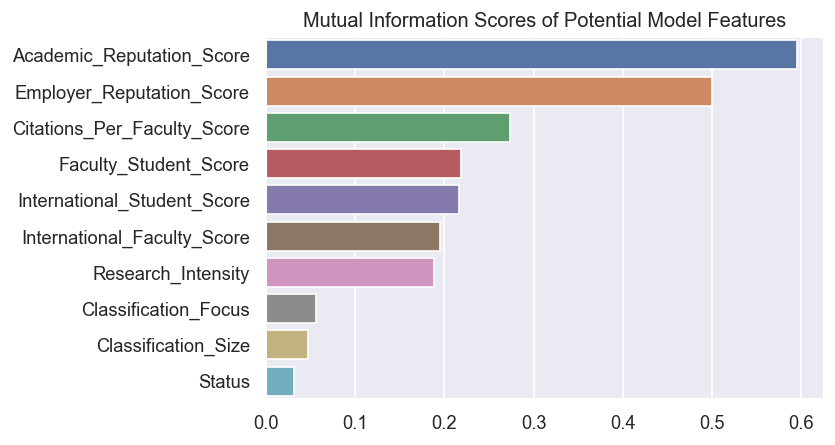

In [7]:
#  Visualising MI scores
plt.figure(dpi=120)
sns.barplot(x = mi_scores.values, y = mi_scores.index)
plt.title('Mutual Information Scores of Potential Model Features')

As seen from the barplot above, the highest mutual information scores were gotten at Academic_Reputation_Score, Employer_Reputation_Score and Citations_Per_Faculty_score. For model building however, the top 7 highest scoring attributes will be selected as model features.

We'll be excluding Classification_Focus, Classification_Size and Status from our model building

#### Creating Feature Matrix

In [8]:
# First, we'll be dropping the features we don't need
vital_features = [ind for ind in mi_scores.index[:7]]
vital_features

['Academic_Reputation_Score',
 'Employer_Reputation_Score',
 'Citations_Per_Faculty_Score',
 'Faculty_Student_Score',
 'International_Student_Score',
 'International_Faculty_Score',
 'Research_Intensity']

In [9]:
#  Reassinging feature matrix
df_model.drop(labels=['Classification_Focus','Classification_Size','Status' ], axis=1, inplace=True)    

In [10]:
# Recall, we label encoded the Research intensity column when doing the Mutual Information Scoring
df_model['Research_Intensity'].value_counts()

VH    1668
HI     607
MD     184
LO      44
Name: Research_Intensity, dtype: int64

The labels represents;
- 0 = VH( Very High Intense)
- 1 = HI( High Intensity)
- 2 = MD(Medium Intensity)
- 3 = LO(Low Intensity

We have to One-Hot-Encode the Research Intensity Labels, so our model won't see labels with high values as more important

In [11]:
df_model = pd.get_dummies(df_model, columns =["Research_Intensity"], drop_first = False)
df_model.head()

,Academic_Reputation_Score,Employer_Reputation_Score,Faculty_Student_Score,Citations_Per_Faculty_Score,International_Faculty_Score,International_Student_Score,Overall_Score,Research_Intensity_HI,Research_Intensity_LO,Research_Intensity_MD,Research_Intensity_VH
0,100.0,100.0,100.0,99.9,100.0,96.1,100.0,0,0,0,1
1,100.0,100.0,100.0,99.4,99.6,72.7,98.7,0,0,0,1
2,100.0,100.0,98.3,99.9,96.5,75.2,98.4,0,0,0,1
3,99.5,85.4,100.0,100.0,93.4,89.2,97.7,0,0,0,1
4,100.0,100.0,100.0,78.3,97.4,97.7,95.6,0,0,0,1


In [12]:
y = df_model['Overall_Score']
X = df_model.drop(columns=['Overall_Score'], axis=1)

In [13]:
X

,Academic_Reputation_Score,Employer_Reputation_Score,Faculty_Student_Score,Citations_Per_Faculty_Score,International_Faculty_Score,International_Student_Score,Research_Intensity_HI,Research_Intensity_LO,Research_Intensity_MD,Research_Intensity_VH
0,100.0,100.0,100.0,99.9,100.0,96.1,0,0,0,1
1,100.0,100.0,100.0,99.4,99.6,72.7,0,0,0,1
2,100.0,100.0,98.3,99.9,96.5,75.2,0,0,0,1
3,99.5,85.4,100.0,100.0,93.4,89.2,0,0,0,1
4,100.0,100.0,100.0,78.3,97.4,97.7,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2498,34.9,25.1,28.8,24.6,13.4,47.4,0,0,0,1
2499,34.6,26.8,26.3,28.8,36.0,2.6,0,0,0,1
2500,31.9,21.7,34.4,18.9,44.1,7.2,0,0,0,1
2501,33.3,18.4,39.2,21.9,100.0,40.6,1,0,0,0


### Data Preprocessing

In [14]:
# We'll be using MinMaxScaler to scale our Data
scaler = MinMaxScaler()
data_model = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
data_model.head()

,Academic_Reputation_Score,Employer_Reputation_Score,Faculty_Student_Score,Citations_Per_Faculty_Score,International_Faculty_Score,International_Student_Score,Research_Intensity_HI,Research_Intensity_LO,Research_Intensity_MD,Research_Intensity_VH
0,1.000000,1.000000,1.0000,0.998990,1.000000,0.960606,0.0,0.0,0.0,1.0
1,1.000000,1.000000,1.0000,0.993939,0.995947,0.724242,0.0,0.0,0.0,1.0
2,1.000000,1.000000,0.9826,0.998990,0.964539,0.749495,0.0,0.0,0.0,1.0
3,0.994944,0.851172,1.0000,1.000000,0.933131,0.890909,0.0,0.0,0.0,1.0
4,1.000000,1.000000,1.0000,0.780808,0.973658,0.976768,0.0,0.0,0.0,1.0


#### Splitting the Data

We'll be initially splitting into training and test, then later split the training set into training and validation
I do this with proportion 80 % of total data are training dataset and the rest are test dataset. Then I split the training dataset again in to two parts training and validation dataset. The second splitting I use proportion 80% of the training data are training data and the rest of data are validation dataset.

In [15]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
xTrain, xVal, yTrain, yVal = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

### Modelling

We'll be making use of linearRegression algorithm, RandomForest algorithm and DecisionTree algorithm

#### Fitting and validating baseline models

Fitting the model and getting the following metrics for each algorithms;
- mae of each algorithms
- mse of each algorithms
- R_Squared

In [17]:
def model_train(xTrain, yTrain, xVal, yVal):
    random_seed= 0
    all_models = [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor()]
    scores = []
    for i in all_models:
        model = i
        model.fit(xTrain, yTrain)
        y_predicted = model.predict(xVal)
        mse = mean_squared_error(yVal, y_predicted)
        mae = mean_absolute_error(yVal, y_predicted)
        r_squared = r2_score(yVal, y_predicted)
        scores.append({
            'model':i,
            'best_score':model.score(xTrain, yTrain),
            'mean_squared_error':mse,
            'mean_absolute_error':mae,
            'R_Squared': r_squared
        })
    return pd.DataFrame(scores, columns=['model','best_score','mean_squared_error','mean_absolute_error', 'R_Squared'])

model_train(xTrain, yTrain, xVal, yVal)

,model,best_score,mean_squared_error,mean_absolute_error,R_Squared
0,LinearRegression(),0.781442,84.864504,7.104788,0.816503
1,"(DecisionTreeRegressor(max_features=1.0, rando...",0.986180,28.196077,3.778035,0.939033
2,DecisionTreeRegressor(),1.000000,58.711147,5.072070,0.873053


The Second model is the Randomforest.

The RandomForest model will be chosen for having the best performance amongst the models used for training and validation.

The RandomForest model produced the smallest mean_abosolute error and the highest R_Squared value.

#### Fitting and Testing the final model (RandomForest)

In [20]:
rf_model = RandomForestRegressor(max_features=1.0, bootstrap=True, criterion='mae')
rf_model.fit(X_train, y_train)
final_pred = rf_model.predict(x_test)
mae_final = mean_absolute_error(y_test, final_pred)
model_score = rf_model.score(x_test, y_test)
print('This is MAE score of final model:', round(mae_final, 3))
print('This is the Score of the final model:', round(model_score, 2))

This is MAE score of final model: 4.043
This is the Score of the final model: 0.91


### Model Explainer

Model explanation will be done using SHAP values. SHAP values help to determine the contribution of each feature to the predicted Overall score

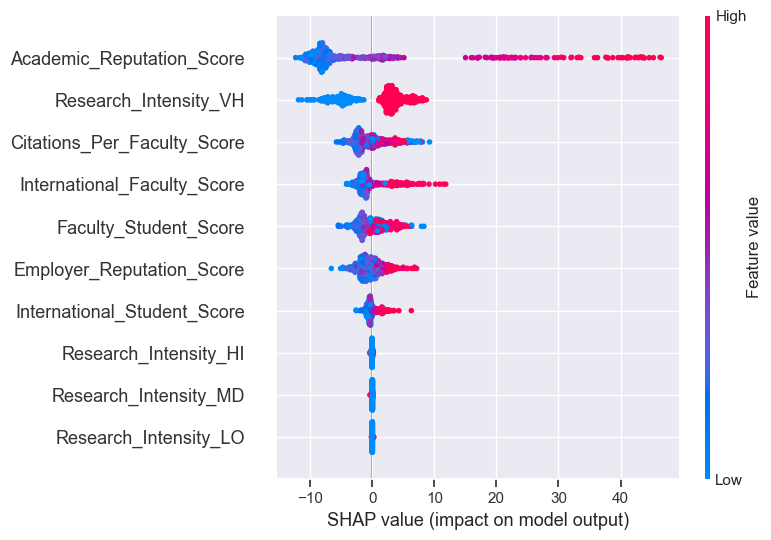

In [19]:
import shap # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf_model)

# Calculate shap values. This what we will plot.
# Calculate shap_values for all of X_test
shap_values = explainer.shap_values(x_test)

# Make plot. Index of [1] is explained in text below
plt.figure(dpi=100)
shap.summary_plot(shap_values, x_test)

The SHAP summary_plot above shows;

- High values of Academic_Reputaion_Score leads to higher Overall score which can help increase a university's rank.
- We can also see that Very High research intensity contributes to higher rankings of universities.
- Universities having just High, Medium & Low research intensity rates doesn't affect their rank.
- High International Faculty score also contributes to higher rankings of universities i.e higher ranking universities provide a multinational environment, building international sympathies and global awareness which has impacted their rank Scores 